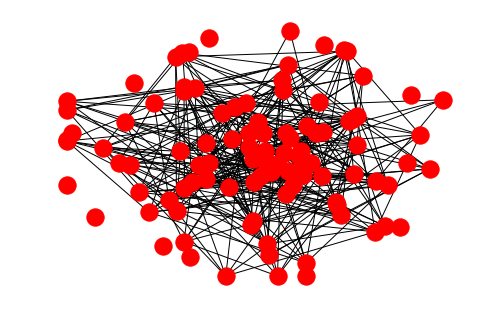

In [9]:
import networkx as nx
import random as rand
from utils import *

class Person(object):
    #static variable
    population = 0
    def __init__(self,id_num=None,ideo=None, capacity=10.0):
        self.id_num = id_num if id_num!=None else Person.population
        Person.population += 1
        self.ideo = ideo if ideo!=None else rand.uniform(-1,1)
        self.capacity = capacity
    def __eq__(self,other):
        if not (isinstance(other,Person)):
            return False
        return self.id_num==other.id_num
    def __hash__(self):
        return hash(self.id_num)

def clamp(x,lo=0,hi=1):
    return lo if x<lo else \
           hi if x>hi else x

def update_friendships(graph, node, sigma=0.1):
    dels = []
    for nbr in graph.adj[node]:
        graph.adj[node][nbr]['weight']= clamp(graph.adj[node][nbr]['weight'] + rand.gauss(0,sigma))
        if graph.adj[node][nbr]['weight']==0:
            dels +=[nbr]
    for nbr in dels:
        graph.remove_edge(node,nbr)

def make_friend(graph, node, p=0.1):
    if rand.random()<p:
        friend = sample(list(graph.nodes()))
    else:
        f = step_rand_walk(graph,node)
        if f==None:
            return
        friend = step_rand_walk(graph,f)
        if friend==None:
            return
    if not (friend == None or node == friend or friend in graph.adj[node]):
        graph.add_edge(node, friend, weight=0.5)
        return friend

def maybe_make_friend(graph, node, p=0.1):
    if rand.random()<=(node.capacity - sum_friend_weights(graph,node))/node.capacity:
        make_friend(graph,node,p)

def sum_friend_weights(graph,node):
    return sum([graph.adj[node][neighbor]['weight'] for neighbor in graph.adj[node]])

def step_rand_walk(graph, node):
    #print(node)
    sum_weights = sum_friend_weights(graph, node)
    if sum_weights==0:
        return None
    li = [(neighbor, graph.adj[node][neighbor]['weight']/sum_weights) for neighbor in graph.adj[node]]
    #print(li)
    x = sample_wp(li)
    #print("hi",x)
    return x

def sample(li):
    if len(li)==0:
        return None
    return li[rand.randint(0,len(li)-1)]

def loop_step(graph):
    for node in graph.nodes():
        update_friendships(graph,node,0.1)
        maybe_make_friend(graph,node,0.1)

def init_graph(pop):
    nodes = [Person() for i in range(pop)]
    G=nx.Graph()
    G.add_nodes_from(nodes)
    return G

def test():
    G = nx.Graph()
    G.add_nodes_from([1,2,3,4,5,6])
    G.add_edges_from([(1,2,{'weight':1.0}),
                      (1,3,{'weight':2.0}),
                      (2,4,{'weight':10.0}),
                      (3,5,{'weight':10.0}),
                      (3,6,{'weight':20.0})])
    #print(G.adj)
    for t in range(15):
        print(step_rand_walk(G,step_rand_walk(G,1)))
    nx.draw(G)
    p=Person()
    q=Person()
    print(Person.population)
    
if __name__=='__main__':
    #test()
    G=init_graph(10)
    for t in range(100):
        loop_step(G)
        if t%10==0:
            nx.draw(G)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.clf()

<Figure size 432x288 with 0 Axes>

NameError: name 'li' is not defined

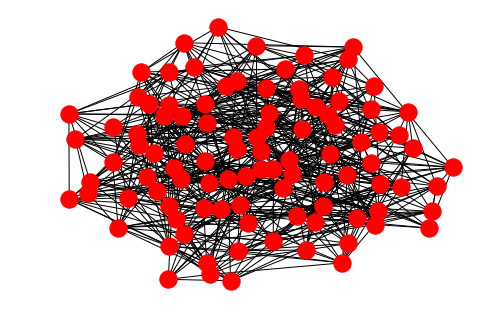

In [16]:
G=init_graph(100)
#print(G.nodes())
for t in range(100):
    loop_step(G)
    if t%10==0:
        plt.clf()
        nx.draw(G)
#nx.draw(G)

In [13]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5,6])
G.nodes()

NodeView((1, 2, 3, 4, 5, 6))

In [16]:
rand.randint(0,2)

0